In [13]:
import torch
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
from torch.fft import fft2, fftshift

In [14]:
class LowPassFilter(torch.nn.Module):
    def __init__(self, rows, cols) -> None:
        super(LowPassFilter, self).__init__()
        self.rows = rows
        self.cols = cols
    
    def forward(self, radius):
        crow, ccol = self.rows // 2 , self.cols // 2
        low_pass = torch.zeros((self.rows, self.cols), dtype=torch.uint8)
        x = torch.arange(0, self.cols).unsqueeze(0).expand(self.rows, self.cols)
        y = torch.arange(0, self.rows).unsqueeze(1).expand(self.rows, self.cols)
        mask_area = (x - ccol) ** 2 + (y - crow) ** 2 <= radius**2
        low_pass[mask_area] = 1
        return low_pass

In [15]:
class Fourier(torch.nn.Module):
    def __init__(self):
        super(Fourier, self).__init__()

    def forward(self, image):
        im_fourier = fftshift(fft2(image))
        return torch.log(torch.abs(im_fourier) + 1)

In [16]:
class ClippedFourier(torch.nn.Module):
    def __init__(self, im_max=1.0, low_pass_radius=25, im_size=(128, 128)):
        super(ClippedFourier, self).__init__()
        self.im_max = torch.tensor(im_max)
        self.threshold = low_pass_radius
        self.low_pass = LowPassFilter(im_size[0], im_size[1])

    def forward(self, image):
        im_fourier = fftshift(fft2(image)) * self.low_pass(self.threshold)
        return torch.log(torch.abs(im_fourier) + 1)

In [17]:
def plot_im(im1, title1, im2, title2):
    plt.figure(figsize=(12, 6))
    plt.subplot(121), plt.imshow(im1.squeeze().cpu().detach().numpy(), cmap='gray')
    plt.title(title1), plt.xticks([]), plt.yticks([])

    plt.subplot(122), plt.imshow(im2.squeeze().cpu().detach().numpy(), cmap='gray')
    plt.title(title2), plt.xticks([]), plt.yticks([])

    plt.show()
    plt.clf()  # Clear the figure

In [18]:
path = "/home/jakobtroidl/Desktop/neural-volumes/logs/hemibrain-volume-noisy-loss-ablation/results_iteration_49/16324_18080_18553/result/result_0_psnr_20,715827632166093.png"
reconstruction = torch.from_numpy(cv2.imread(path, cv2.IMREAD_GRAYSCALE))

path = "/home/jakobtroidl/Desktop/neural-volumes/logs/hemibrain-volume-noisy-loss-ablation/results_iteration_34/16324_18080_18553/gt/gt_0.png"
gt = torch.from_numpy(cv2.imread(path, cv2.IMREAD_GRAYSCALE))

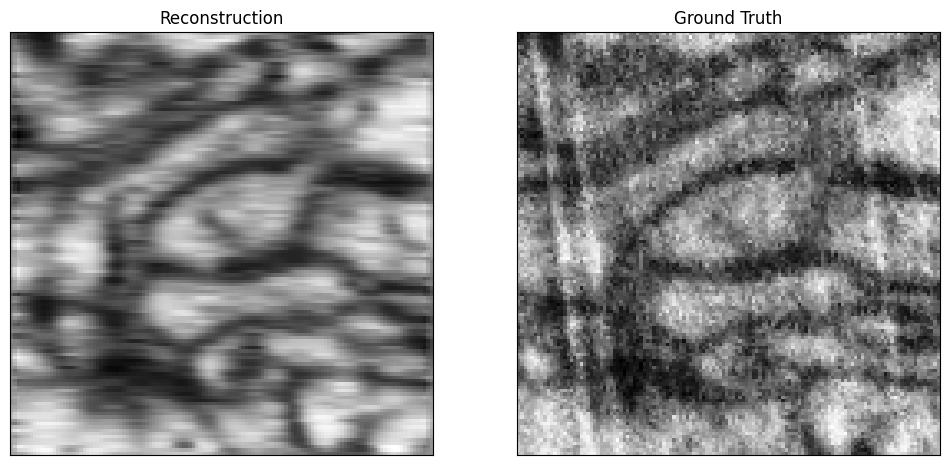

<Figure size 640x480 with 0 Axes>

In [19]:
plot_im(reconstruction, "Reconstruction", gt, "Ground Truth")

In [20]:
print(reconstruction.shape)
print(gt.shape)
print("Min max of reconstruction: ", reconstruction.min(), reconstruction.max())
print("Min max of gt: ", gt.min(), gt.max())

torch.Size([128, 128])
torch.Size([128, 128])
Min max of reconstruction:  tensor(6, dtype=torch.uint8) tensor(251, dtype=torch.uint8)
Min max of gt:  tensor(11, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


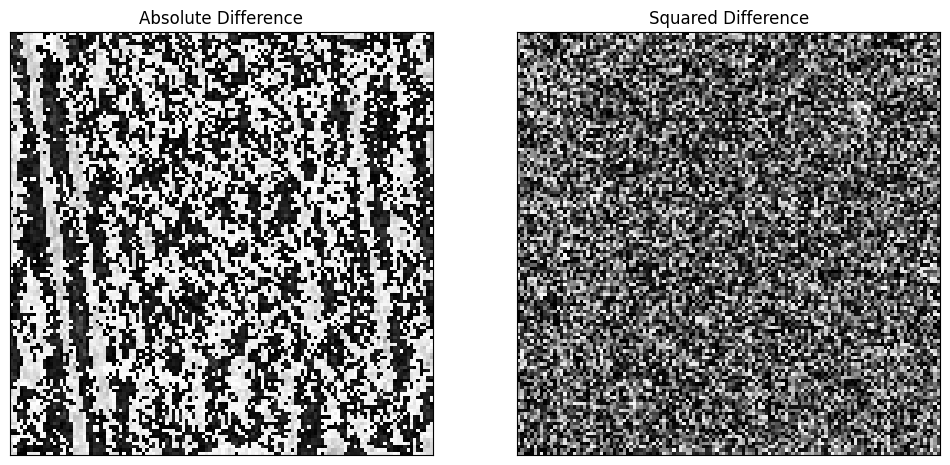

<Figure size 640x480 with 0 Axes>

In [21]:
plot_im(torch.abs(reconstruction - gt), "Absolute Difference", (reconstruction - gt)**2, "Squared Difference")

In [22]:
cf = ClippedFourier()
fourier = Fourier()

reconstruction_fourier = fourier(reconstruction)
gt_fourier = fourier(gt)


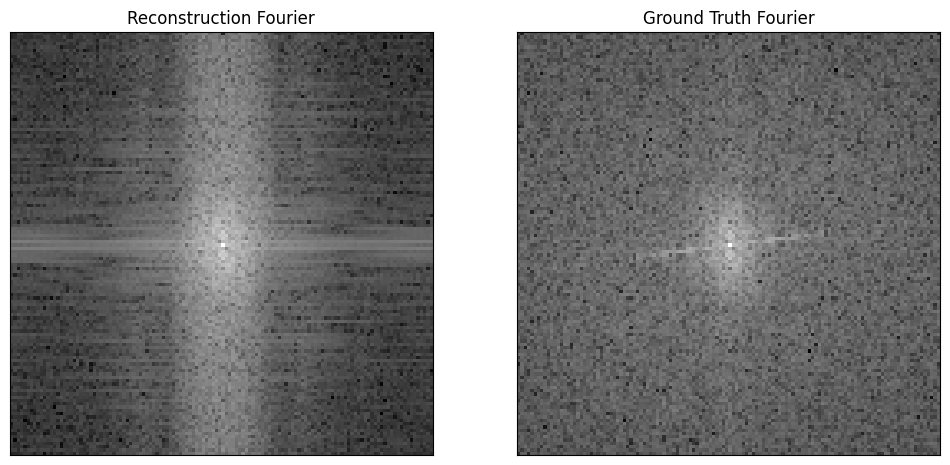

<Figure size 640x480 with 0 Axes>

In [23]:
plot_im(reconstruction_fourier, "Reconstruction Fourier", gt_fourier, "Ground Truth Fourier")

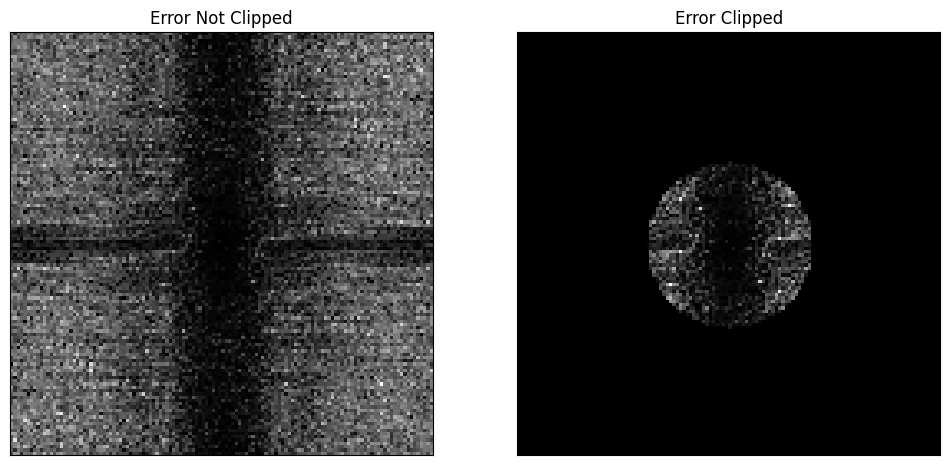

<Figure size 640x480 with 0 Axes>

In [24]:

reconstruction_cf_fourier = cf(reconstruction)
gt_cf_fourier = cf(gt)

diff_fourier = torch.abs(gt_fourier - reconstruction_fourier)
diff_clipped = torch.abs(gt_cf_fourier - reconstruction_cf_fourier)

plot_im(diff_fourier, "Error Not Clipped", diff_clipped, "Error Clipped")